EiGroup Technical Task - Section 3 {-}
===
**Author: Abbas Aliyev**

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.ndimage import gaussian_filter
from skimage.filters.rank import threshold
from tqdm.notebook import tqdm
import gc
from scipy import stats
from skimage import filters, feature, transform
from skimage.transform import radon

In [100]:
data = np.loadtxt("data/Section 3 data.csv", delimiter=',')
data_normalized = (data - np.min(data)) / (np.max(data) - np.min(data))

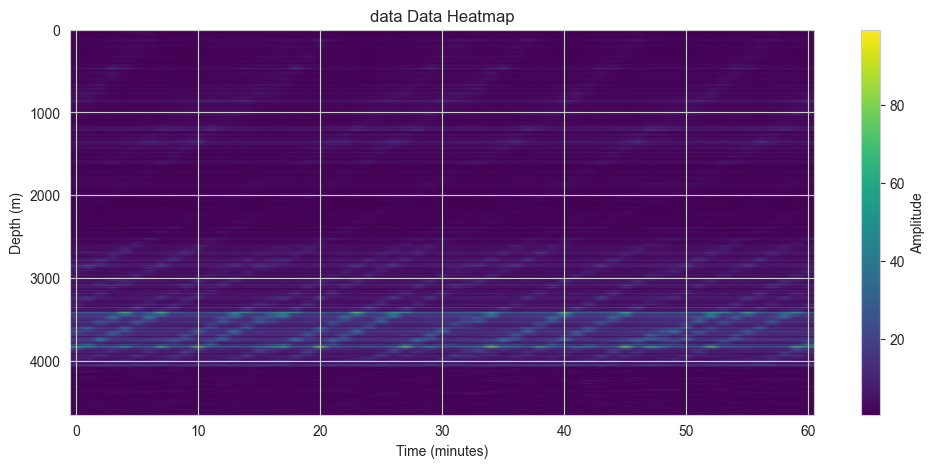

In [153]:
plt.figure(figsize=(12, 5))
plt.imshow(data, aspect='auto', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title("data Data Heatmap")
plt.xlabel("Time (minutes)")
plt.ylabel("Depth (m)")
plt.show()

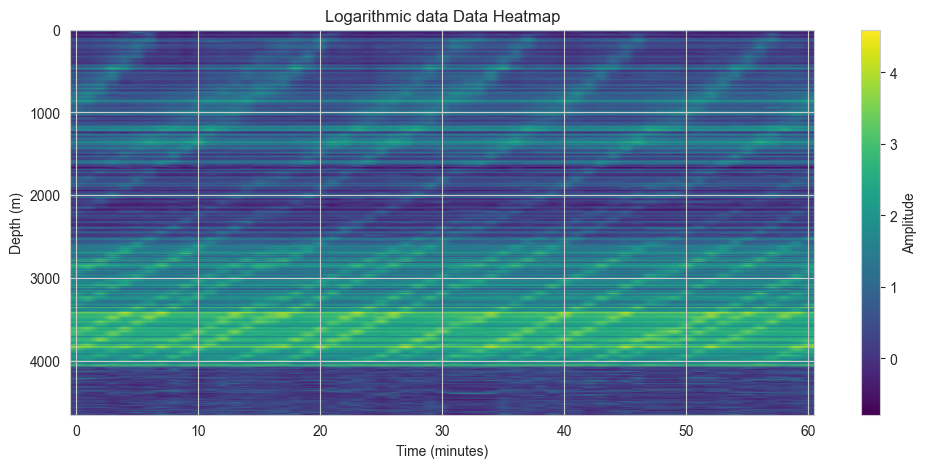

In [154]:
data_log = np.log(data)
plt.figure(figsize=(12, 5))
plt.imshow(data_log, aspect='auto', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title("Logarithmic data Data Heatmap")
plt.xlabel("Time (minutes)")
plt.ylabel("Depth (m)")
plt.show()

In [102]:
print(data.shape)
print(data.dtype)

(4654, 61)
float64


In [103]:
# Basic statistics
print("Basic Statistics:")
print(f"Mean value: {np.mean(data):.4f}")
print(f"Median value: {np.median(data):.4f}")
print(f"Standard deviation: {np.std(data):.4f}")
print(f"Min value: {np.min(data):.4f}")
print(f"Max value: {np.max(data):.4f}")
print(f"Data range: {np.ptp(data):.4f}")  # Peak to peak (max-min)

Basic Statistics:
Mean value: 4.7768
Median value: 2.4708
Standard deviation: 6.1312
Min value: 0.4554
Max value: 99.2133
Data range: 98.7579


In [104]:
# Check for missing or infinite values
print("\nData Quality:")
print(f"Number of NaN values: {np.isnan(data).sum()}")
print(f"Number of infinite values: {np.isinf(data).sum()}")


Data Quality:
Number of NaN values: 0
Number of infinite values: 0


In [105]:
# Distribution analysis
flat_data = data.flatten()
skewness = stats.skew(flat_data)
kurtosis = stats.kurtosis(flat_data)
print("\nDistribution Statistics:")
print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")


Distribution Statistics:
Skewness: 3.7003
Kurtosis: 22.1511


In [106]:
# Spatial and temporal statistics
spatial_means = np.mean(data, axis=1)  # Mean along time for each depth
temporal_means = np.mean(data, axis=0)  # Mean along depth for each time

print("\nSpatial Statistics (along depth):")
print(f"Max spatial mean: {np.max(spatial_means):.4f}")
print(f"Min spatial mean: {np.min(spatial_means):.4f}")
print(f"Spatial mean std: {np.std(spatial_means):.4f}")

print("\nTemporal Statistics (along time):")
print(f"Max temporal mean: {np.max(temporal_means):.4f}")
print(f"Min temporal mean: {np.min(temporal_means):.4f}")
print(f"Temporal mean std: {np.std(temporal_means):.4f}")


Spatial Statistics (along depth):
Max spatial mean: 52.8047
Min spatial mean: 0.6713
Spatial mean std: 5.6612

Temporal Statistics (along time):
Max temporal mean: 5.0466
Min temporal mean: 4.5634
Temporal mean std: 0.1089


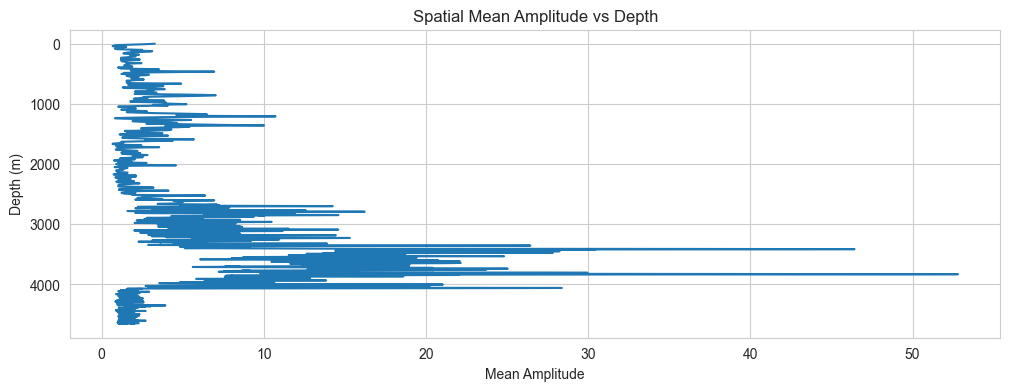

In [108]:
# Spatial Mean vs Depth
spatial_mean = data.mean(axis=1)
plt.figure(figsize=(12, 4))
plt.plot(spatial_mean, range(len(spatial_mean)))
plt.gca().invert_yaxis()
plt.title("Spatial Mean Amplitude vs Depth")
plt.xlabel("Mean Amplitude")
plt.ylabel("Depth (m)")
plt.show()

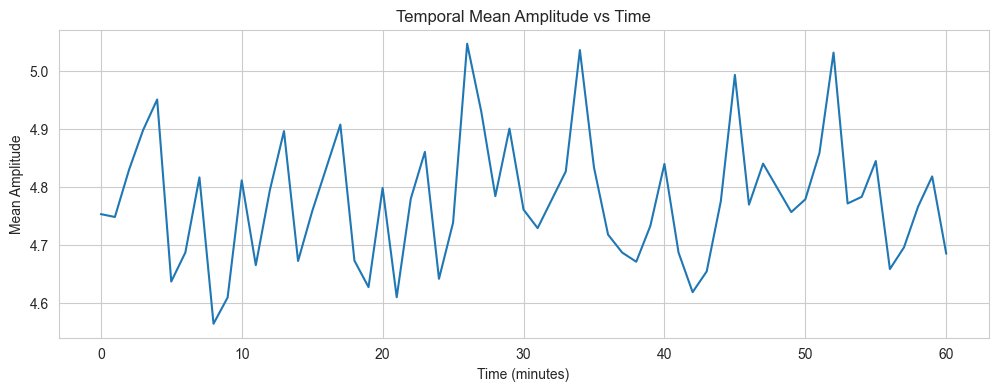

In [109]:
# Temporal Mean vs Time
temporal_mean = data.mean(axis=0)
plt.figure(figsize=(12, 4))
plt.plot(temporal_mean)
plt.title("Temporal Mean Amplitude vs Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Mean Amplitude")
plt.show()

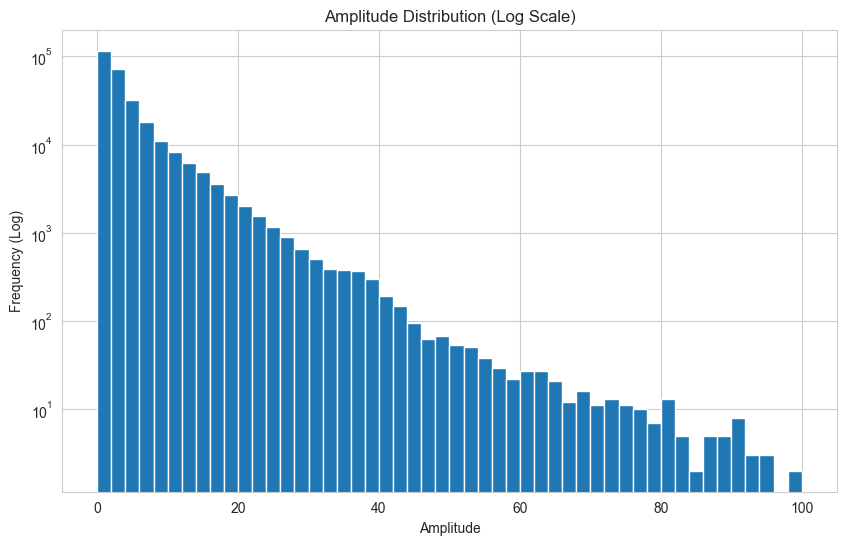

In [110]:
# Amplitude Distribution
plt.figure(figsize=(10, 6))
plt.hist(data.flatten(), bins=50, log=True, range=(0, 100))
plt.title("Amplitude Distribution (Log Scale)")
plt.xlabel("Amplitude")
plt.ylabel("Frequency (Log)")
plt.show()

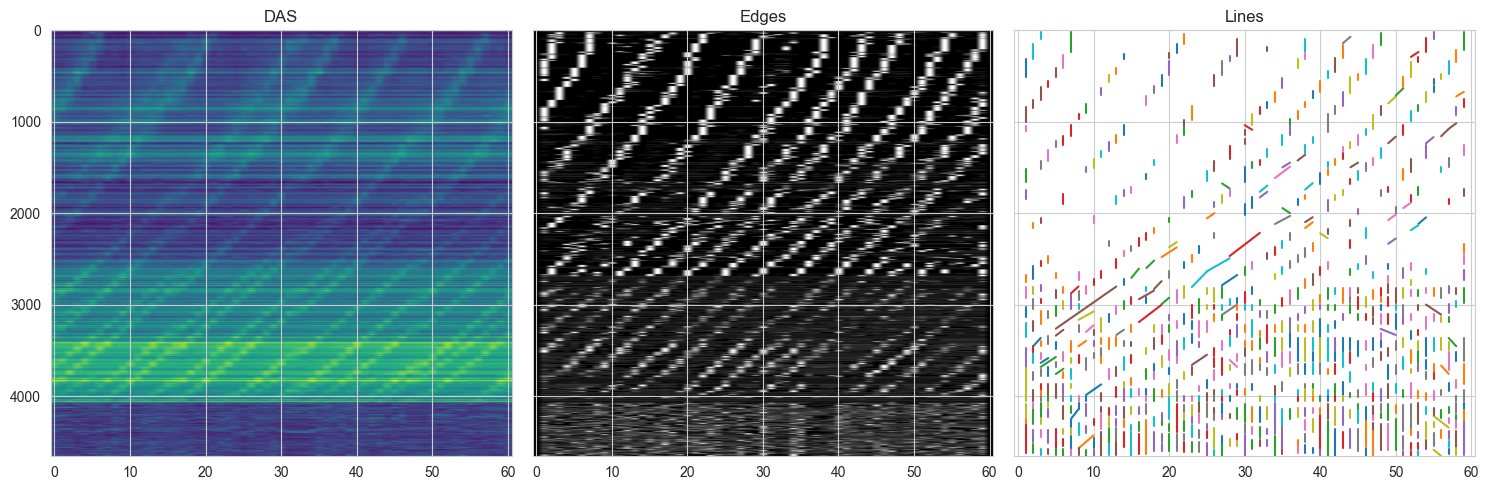

In [143]:
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny

data_edges = canny(data_log, 2)
data_lines = probabilistic_hough_line(data_edges, 50, 50, 10)
fig, axes = plt.subplots(1, 3, figsize = (15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(data_log, aspect='auto', cmap='viridis')
ax[0].set_title('data')

ax[1].imshow(data_edges, aspect='auto', cmap='gray')
ax[1].set_title('Edges')

for line in data_lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))


ax[2].set_title('Lines')
#
plt.tight_layout()
plt.show()

In [144]:
from skimage.transform import hough_line, hough_line_peaks

threshold = 0.6
min_distance = 50
min_angle = 60

# Get image dimensions
n_rows, n_cols = data.shape

# Log transform and normalize
data_log = np.log(data)
data_normalized = (data_log - np.min(data_log)) / (np.max(data_log) - np.min(data_log))

# Apply Hough transform
tested_angles = np.linspace(0, np.pi/2, 720)
h, theta, d = hough_line(data_normalized, theta=tested_angles)

# Find peaks in Hough space
peaks = hough_line_peaks(h, theta, d,
                       num_peaks=10,
                       threshold=threshold*np.max(h),
                       min_distance=min_distance,
                       min_angle=min_angle)

# Extract line parameters
lines = []
for _, angle, dist in zip(*peaks):
    # Calculate line points
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
    x0 = dist * cos_a
    y0 = dist * sin_a

    # Calculate points that intersect with image boundaries
    if abs(sin_a) < 1e-10:  # Vertical line
        x1 = x2 = int(dist / cos_a)
        y1, y2 = 0, n_rows - 1
    else:
        # Find intersections with all image boundaries
        x_bounds = [0, n_cols - 1]
        y_bounds = [0, n_rows - 1]
        points = []
        # Check intersections with horizontal boundaries
        for y in y_bounds:
            x = (dist - y * sin_a) / cos_a
            if 0 <= x < n_cols:
                points.append((x, y))

        # Check intersections with vertical boundaries
        for x in x_bounds:
            y = (dist - x * cos_a) / sin_a
            if 0 <= y < n_rows:
                points.append((x, y))

        # Sort points and take the first and last unique ones
        points = list(set(points))
        if len(points) >= 2:
            points.sort()
            (x1, y1), (x2, y2) = points[:2]
        else:
            continue  # Skip if we don't have enough points
    lines.append(((int(x1), int(y1)), (int(x2), int(y2)), angle, dist))

lines_with_params = []
for _, angle, dist in zip(*peaks):
    # Previous line point calculations...

    # Convert to slope-intercept form
    if abs(x2 - x1) < 1e-10:  # Vertical line
        slope = float('inf')
        intercept = x1  # x = c form for vertical lines
    else:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1

    lines_with_params.append({
        'points': ((int(x1), int(y1)), (int(x2), int(y2))),
        'angle': angle,
        'distance': dist,
        'slope': slope,
        'intercept': intercept
    })


Line equation: y = -91.54x + 5035.13
Speed: 91.54 meters/minute (5492.54 meters/hour)


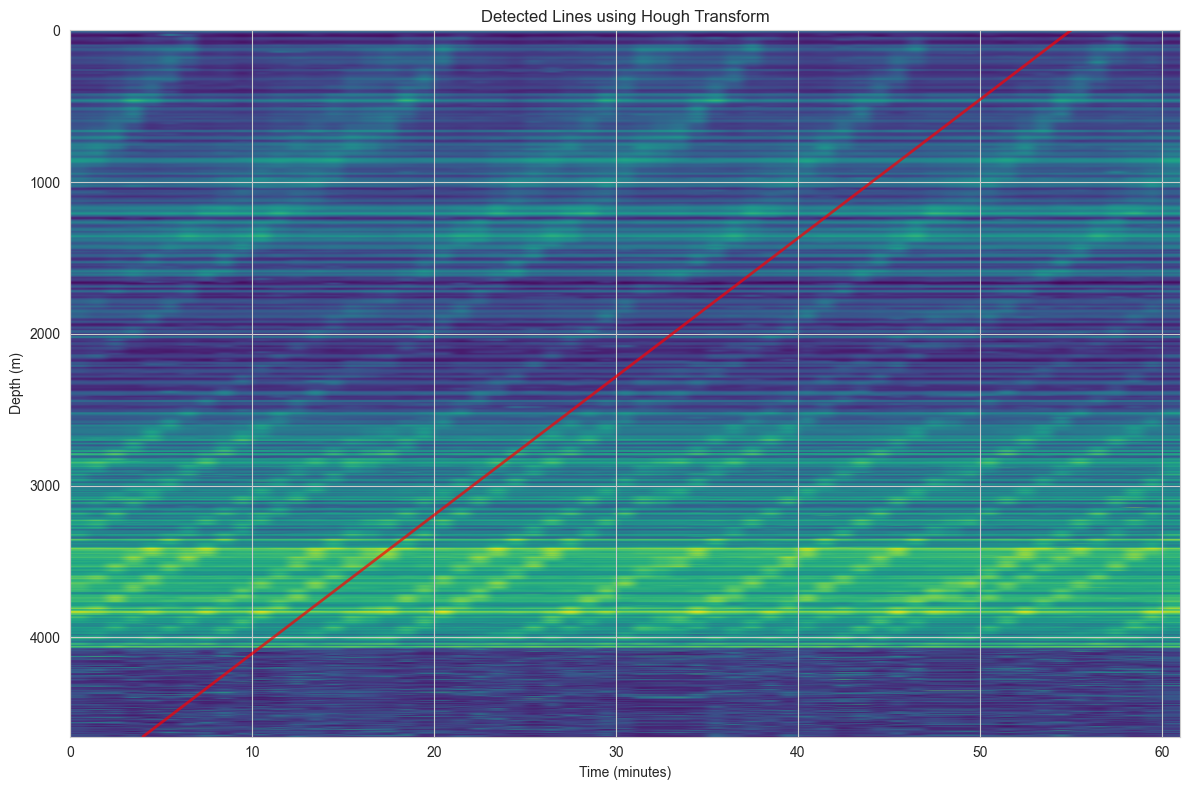

In [147]:
plt.figure(figsize=(12, 8))
plt.imshow(np.log(data), aspect='auto', cmap='viridis', extent=[0, data.shape[1], data.shape[0], 0])

for line in lines_with_params:
    (x1, y1), (x2, y2) = line['points']
    slope = line['slope']
    intercept = line['intercept']

    plt.plot([x1, x2], [y1, y2], 'r-', alpha=0.7, linewidth=2)

    # Print line parameters
    if slope != float('inf'):
        print(f"Line equation: y = {slope:.2f}x + {intercept:.2f}")
        # Calculate speed (assuming 1 unit on x-axis = 1 minute, 1 unit on y-axis = 1 meter)
        speed = abs(slope)  # meters per minute
        print(f"Speed: {speed:.2f} meters/minute ({speed*60:.2f} meters/hour)")
    else:
        print("Vertical line: x =", x1)

plt.title("Detected Lines using Hough Transform")
plt.xlabel("Time (minutes)")
plt.ylabel("Depth (m)")
plt.tight_layout()
plt.show()

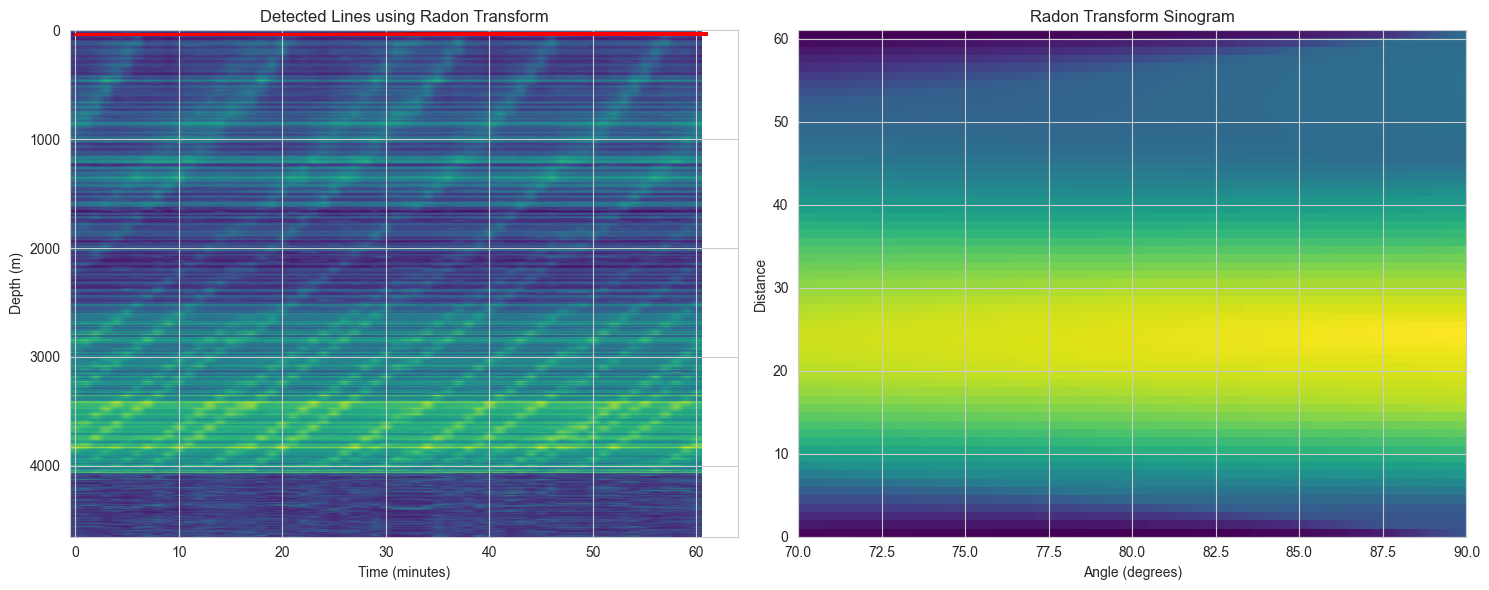

Line 1:
  Angle: 84.53°
  Slope: -0.10
  Speed: 10.43 meters/minute (626.00 meters/hour)
  Intercept: 35.16

Line 2:
  Angle: 84.64°
  Slope: -0.09
  Speed: 10.65 meters/minute (639.12 meters/hour)
  Intercept: 35.15

Line 3:
  Angle: 84.75°
  Slope: -0.09
  Speed: 10.88 meters/minute (652.80 meters/hour)
  Intercept: 35.15

Line 4:
  Angle: 84.86°
  Slope: -0.09
  Speed: 11.12 meters/minute (667.07 meters/hour)
  Intercept: 35.14

Line 5:
  Angle: 84.97°
  Slope: -0.09
  Speed: 11.37 meters/minute (681.97 meters/hour)
  Intercept: 35.14

Line 6:
  Angle: 85.08°
  Slope: -0.09
  Speed: 11.63 meters/minute (697.55 meters/hour)
  Intercept: 35.13

Line 7:
  Angle: 85.20°
  Slope: -0.08
  Speed: 11.90 meters/minute (713.85 meters/hour)
  Intercept: 35.12

Line 8:
  Angle: 85.31°
  Slope: -0.08
  Speed: 12.18 meters/minute (730.93 meters/hour)
  Intercept: 35.12

Line 9:
  Angle: 85.42°
  Slope: -0.08
  Speed: 12.48 meters/minute (748.84 meters/hour)
  Intercept: 35.11

Line 10:
  Angle: 8

In [150]:
from skimage.transform import radon, iradon
import numpy as np
import matplotlib.pyplot as plt

def detect_lines_radon(data, threshold_percentile=95, theta=None):
    # Log transform the data
    data_log = np.log(data)
    
    # Normalize data to [0,1]
    data_normalized = (data_log - np.min(data_log)) / (np.max(data_log) - np.min(data_log))
    
    # Define angles for Radon transform
    if theta is None:
        theta = np.linspace(70, 90, 180)
    
    # Apply Radon transform
    sinogram = radon(data_normalized, theta=theta)
    
    # Find peaks in the sinogram
    threshold = np.percentile(sinogram, threshold_percentile)
    peaks = np.where(sinogram > threshold)
    
    # Convert peaks to line parameters
    lines = []
    for angle, dist in zip(theta[peaks[1]], peaks[0]):
        # Convert from Radon space to image space
        angle_rad = np.deg2rad(angle)
        a = -np.cos(angle_rad) / np.sin(angle_rad) if np.sin(angle_rad) != 0 else float('inf')
        b = dist / np.sin(angle_rad) if np.sin(angle_rad) != 0 else dist
        
        # Calculate line endpoints
        if a != float('inf'):
            # For non-vertical lines
            x1, x2 = 0, data.shape[1]
            y1 = a * x1 + b
            y2 = a * x2 + b
        else:
            # For vertical lines
            x1 = x2 = dist
            y1, y2 = 0, data.shape[0]
            
        lines.append({
            'points': ((int(x1), int(y1)), (int(x2), int(y2))),
            'slope': a,
            'intercept': b,
            'angle': angle
        })
    
    return lines, sinogram

# Apply detection
lines, sinogram = detect_lines_radon(data, threshold_percentile=98)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot original data with detected lines
ax1.imshow(np.log(data), aspect='auto', cmap='viridis')
for line in lines:
    (x1, y1), (x2, y2) = line['points']
    if 0 <= y1 <= data.shape[0] and 0 <= y2 <= data.shape[0]:  # Only plot if within bounds
        ax1.plot([x1, x2], [y1, y2], 'r-', alpha=0.5)
ax1.set_title('Detected Lines using Radon Transform')
ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Depth (m)')

# Plot sinogram
ax2.imshow(sinogram, aspect='auto', 
           extent=(70, 90, 0, sinogram.shape[0]),
           cmap='viridis')
ax2.set_title('Radon Transform Sinogram')
ax2.set_xlabel('Angle (degrees)')
ax2.set_ylabel('Distance')

plt.tight_layout()
plt.show()

# Print line parameters
for i, line in enumerate(lines):
    slope = line['slope']
    intercept = line['intercept']
    angle = line['angle']
    if slope != float('inf'):
        speed = abs(1/slope) if slope != 0 else float('inf')
        print(f"Line {i+1}:")
        print(f"  Angle: {angle:.2f}°")
        print(f"  Slope: {slope:.2f}")
        print(f"  Speed: {speed:.2f} meters/minute ({speed*60:.2f} meters/hour)")
        print(f"  Intercept: {intercept:.2f}")
        print()